# CNN model using Pytorch

## Import libraries

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

PyTorch Version:  2.3.0+cu121
Torchvision Version:  0.18.0+cu121


## Load the Data

In [2]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_letters/lett

## View Data

In [3]:
# Preparar el dataset
train_data = pd.read_csv('written_letters_train.csv')
valid_data = pd.read_csv('written_letters_validation.csv')

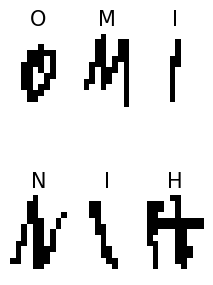

In [4]:
plt.figure(figsize=(2.5, 3.5))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_letters/'+train_data.loc[i, 'id']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_data.loc[i, 'nombre'], fontsize=15)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [5]:
print("Number of NaNs in train set      : ", train_data['nombre'].isnull().sum())
print("Number of NaNs in validation set : ", valid_data['nombre'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [6]:
train_data.dropna(axis=0, inplace=True)
valid_data.dropna(axis=0, inplace=True)

In [7]:
train_data = train_data[train_data['nombre'] != 'UNREADABLE']
valid_data = valid_data[valid_data['nombre'] != 'UNREADABLE']

In [8]:
train_data['nombre'] = train_data['nombre'].str.upper()
valid_data['nombre'] = valid_data['nombre'].str.upper()

In [9]:
train_data.reset_index(inplace = True, drop=True)
valid_data.reset_index(inplace = True, drop=True)

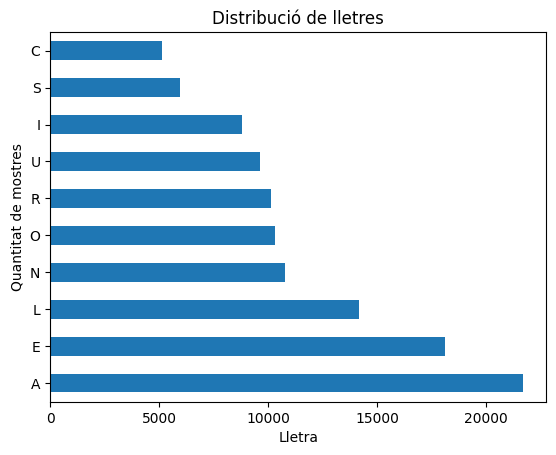

nombre
A    21687
E    18122
L    14201
N    10797
O    10319
R    10160
U     9636
I     8816
S     5945
C     5128
Name: count, dtype: int64


In [10]:
letter_count = train_data['nombre'].value_counts()

letter_count[:10].plot(kind='barh')
plt.title('Distribució de lletres')
plt.xlabel('Lletra')
plt.ylabel('Quantitat de mostres')
plt.show()

print(letter_count[:10])

## Preprocessing Images for Training

In [11]:
class HandwritingDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels_encoded = self.label_encoder.fit_transform(self.df.iloc[:, 1])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert("L")  # Convert to grayscale
        label = self.labels_encoded[idx]  # Use the encoded label

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to a standard size
    transforms.ToTensor(),  # Convert image to tensor
])

Split the datasets:

In [13]:
# Combine the training and validation DataFrames
combined_data = pd.concat([train_data, valid_data])

# Separate features and labels
X = combined_data.drop(columns=['nombre'])
y = combined_data['nombre']

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=300/(3000+300), stratify=y, random_state=42)

# Combine features and labels back into DataFrames
train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_valid, y_valid], axis=1)

# Verify the class distribution
print('Training class distribution:\n', train_data['nombre'].value_counts())
print('Validation class distribution:\n', valid_data['nombre'].value_counts())

Training class distribution:
 nombre
A    22216
E    18677
L    14574
N    11079
O    10659
R    10438
U     9905
I     9020
S     6086
C     5290
H     4984
M     4635
T     4588
D     3708
G     2651
Y     2497
B     2325
P     1915
V     1907
F     1516
X     1038
Z      978
K      950
J      659
       614
-      584
Q      195
W      141
'       27
Name: count, dtype: int64
Validation class distribution:
 nombre
A    2222
E    1868
L    1457
N    1108
O    1066
R    1044
U     991
I     902
S     609
C     529
H     498
M     464
T     459
D     371
G     265
Y     250
B     232
P     191
V     191
F     151
X     104
Z      98
K      95
J      66
       61
-      58
Q      19
W      14
'       3
Name: count, dtype: int64


Balance the labels:

In [15]:
from sklearn.utils.class_weight import compute_class_weight

# Get the class labels
class_labels = train_data['nombre'].unique()
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_data['nombre'])

# Convert to tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [16]:
# train_data, valid_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)

# # Adjusting the size of train_data to 3000 samples
# train_data = train_data.sample(n=3000, random_state=42)

# # Adjusting the size of valid_data to 300 samples
# valid_data = valid_data.sample(n=300, random_state=42)

In [17]:
train_dataset = HandwritingDataset(root_dir='train_letters/', csv_file="written_letters_train.csv", transform=transform)
valid_dataset = HandwritingDataset(root_dir='valid_letters/', csv_file="written_letters_validation.csv", transform=transform)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Verify de data loaders work correctly:

In [19]:
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(images.shape)  # This will give you the shape of the batch of images
    print(labels.shape)  # And this will give you the shape of the batch of labels
    break  # Just to demonstrate, stop after the first batch

Batch 0:
torch.Size([32, 1, 28, 28])
torch.Size([32])


## Training function

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        self.best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(self.best_model_wts, 'checkpoint.pt')

In [26]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "valid": []}
    losses = {"train": [], "valid": []}  # Store average losses per epoch

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    early_stopping = EarlyStopping(patience=5, delta=0)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Save the average loss for the epoch
            losses[phase].append(epoch_loss)

            if phase == 'valid':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping(epoch_loss, model)

            acc_history[phase].append(epoch_acc)

        print()

        if early_stopping.early_stop:
            print("Early stopping")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    if early_stopping.best_model_wts is not None:
        model.load_state_dict(early_stopping.best_model_wts)
    else:
        model.load_state_dict(best_model_wts)
    return model, acc_history, losses

## Initialize model

In [27]:
def initialize_model(num_classes):
    # Resnet18
    model = models.resnet18(weights = None)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features=512, out_features=num_classes, bias=True))

    input_size = 224

    return model, input_size

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
# Number of classes in the dataset
num_classes = len(alphabets)
print('num classes:', num_classes)

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)

num classes: 29
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

## Run Training and Validation

In [28]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Number of epochs to train fors
num_epochs = 10

optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

dataloaders_dict = {"train": train_loader, "valid": valid_loader}

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.5512 Acc: 0.7666
valid Loss: 0.3829 Acc: 0.8776

Epoch 1/9
----------
train Loss: 0.3283 Acc: 0.8712
valid Loss: 0.3039 Acc: 0.9112

Epoch 2/9
----------
train Loss: 0.2787 Acc: 0.8950
valid Loss: 0.2912 Acc: 0.9175

Epoch 3/9
----------
train Loss: 0.2512 Acc: 0.9037
valid Loss: 0.3057 Acc: 0.8932

Epoch 4/9
----------
train Loss: 0.2312 Acc: 0.9112
valid Loss: 0.2705 Acc: 0.9222

Epoch 5/9
----------
train Loss: 0.2142 Acc: 0.9170
valid Loss: 0.2713 Acc: 0.9220

Epoch 6/9
----------
train Loss: 0.2024 Acc: 0.9215
valid Loss: 0.2683 Acc: 0.9280

Epoch 7/9
----------
train Loss: 0.1943 Acc: 0.9231
valid Loss: 0.2741 Acc: 0.9299

Epoch 8/9
----------
train Loss: 0.1797 Acc: 0.9282
valid Loss: 0.2875 Acc: 0.9323

Epoch 9/9
----------
train Loss: 0.1737 Acc: 0.9304
valid Loss: 0.3145 Acc: 0.9292

Training complete in 24m 50s
Best val Acc: 0.932332


In [29]:
torch.save(model.state_dict(), 'cnn_model_v5.pth')

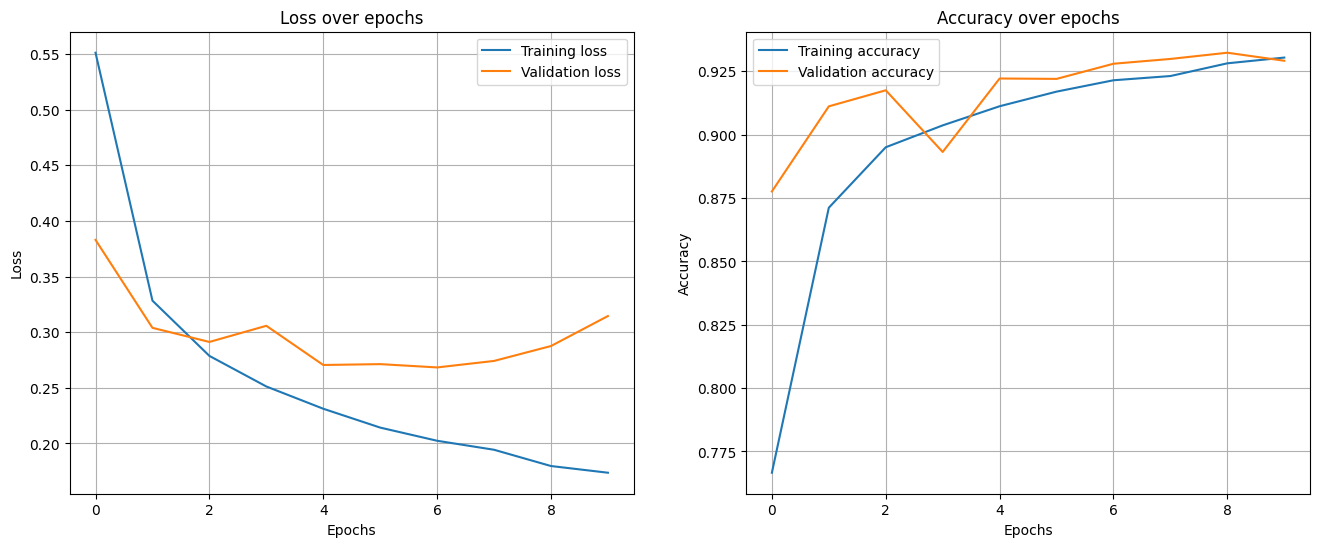

In [30]:
train_losses = losses["train"]
val_losses = losses["valid"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation losses
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

train_accuracies = [acc.cpu().detach().numpy() for acc in hist['train']]
val_accuracies = [acc.cpu().detach().numpy() for acc in hist['valid']]

# Plot the training and validation accuracies
ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(val_accuracies, label='Validation accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()
